In [1]:
import os
import tomopy
import numpy as np
from imars3d.filters import tilt
import matplotlib.pyplot as plt
import sys
root_folder = os.path.dirname(os.getcwd())
sys.path.append(root_folder)
import utilities as rocku
import dxchange
import algotom.io.loadersaver as losa
import algotom.prep.correction as corr
import algotom.io.converter as conv
import algotom.prep.calculation as calc
import algotom.rec.reconstruction as rec
import bm3d_streak_removal as bm3d
import h5py as h5f
from tqdm import tqdm
import timeit
import multiprocessing as mp
# from joblib import Parallel, delayed

olefile module not found


In [2]:
# %matplotlib notebook
%matplotlib inline

In [3]:
ncore = 48
if ncore > mp.cpu_count():
    ncore = mp.cpu_count()
ncore

48

# Workflow starts here!

In [4]:
###################### need to change start
ipts="27734"
###################### need to change end

## Find CT scan location

In [5]:
# ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ct_scans"
ct_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(ct_loc)

['2022_09_30_bee_ob',
 '2022_09_30_bee',
 '2022_09_30_bee_dc',
 '2022_10_01_battery']

## Find OB location

In [6]:
# ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/ob"
ob_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(ob_loc)

['2022_09_30_bee_ob',
 '2022_09_30_bee',
 '2022_09_30_bee_dc',
 '2022_10_01_battery']

## Find DC location

In [7]:
# dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/raw/df"
dc_loc = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/raw_to_recon"
os.listdir(dc_loc)

['2022_09_30_bee_ob',
 '2022_09_30_bee',
 '2022_09_30_bee_dc',
 '2022_10_01_battery']

In [8]:
###################### need to change start
sample_name = "2022_09_30_bee"
ct_dir = os.path.join(ct_loc, sample_name)
ob_dir = os.path.join(ob_loc, "2022_09_30_bee_ob")
dc_dir = os.path.join(dc_loc, "2022_09_30_bee_dc")
# ct_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# ob_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
# dc_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/raw_to_recon"
gamma_diff = 20
end_ang = 359.1 # Will not be used if the CT file names contain angle info
ct_name = "*battery*" # Will not be used if follows the default file structure
ob_name = "*ob*" # Will not be used if follows the default file structure
dc_name = "*dc*" # Will not be used if follows the default file structure
output_hdf5_dir = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/hdf5/"
output_hdf5 = output_hdf5_dir + sample_name + ".h5"
###################### need to change end

# Load all data files (CT, OB and DC)

In [9]:
history_dict = {}
######### CT
proj_raw, ang_deg, ang_rad, proj180_idx, proj000_idx, fname_sorted = rocku.load_ct(ct_dir, ang2=end_ang, name=ct_name)
######### OB
ob_raw = rocku.load_ob(ob_dir, name=ob_name)
######### DC
dc_raw = rocku.load_dc(dc_dir, name=dc_name)

Found index of 180 degree projections: 143 of angle 180.18
Found index of 0 degree projections: 0 of angle 0.0
Loading 286 CT projections...


286it [00:55,  5.12it/s]


286 CT projections loaded!
Shape: (286, 4189, 4489)
Loading 1 Open Beam (OB) images...


1it [00:00, 11.48it/s]


1 Open Beam (OB) images loaded!
Shape: (1, 4189, 4489)
Loading 1 Dark Current (DC) images...


1it [00:00, 11.27it/s]

1 Dark Current (DC) images loaded!
Shape: (1, 4189, 4489)


# Visual verification of loaded files

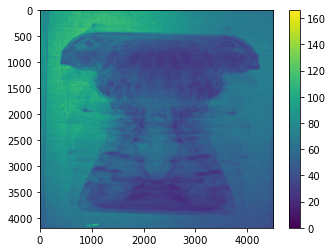

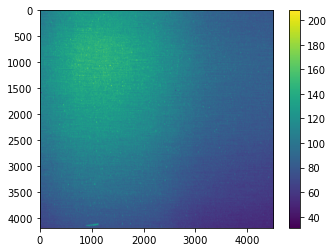

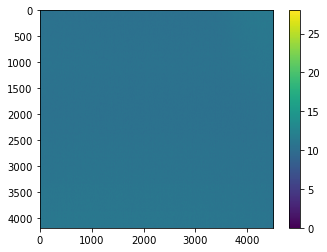

In [10]:
proj_min = np.min(proj_raw, axis=0)
ob_min = np.min(ob_raw, axis=0)
dc_max = np.max(dc_raw, axis=0)
plt.imshow(proj_min)
plt.colorbar()
plt.show()
plt.imshow(ob_min)
plt.colorbar()
plt.show()
plt.imshow(dc_max)
plt.colorbar()
plt.show()

# Define/crop ROI

Recon ROI:


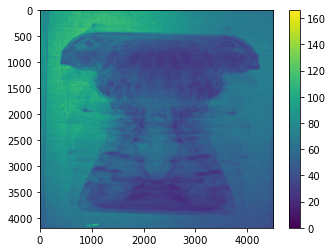

In [11]:
###################### need to change start
crop = False
# crop_left = 250
# crop_right = 1650
# crop_top = 750
# crop_bottom = 1950
crop_left = 550
crop_right = 1500
crop_top = 900
crop_bottom = 1450
###################### need to change end
proj_crop = rocku.crop(proj_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
ob_crop = rocku.crop(ob_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
dc_crop = rocku.crop(dc_raw, crop_left, crop_right, crop_top, crop_bottom, crop)
proj_crop_min = rocku.crop(proj_min, crop_left, crop_right, crop_top, crop_bottom, crop)
print("Recon ROI:")
plt.imshow(proj_crop_min)
plt.colorbar()
plt.show()
crop_roi_dict = {
    'left': crop_left,
    'right': crop_right,
    'top': crop_top,
    'bottom': crop_bottom
}
history_dict = rocku.log(history_dict, 'crop', crop)
if crop:
    history_dict = rocku.log(history_dict, 'crop_roi', crop_roi_dict)

# Remove Outliers

In [12]:
t0 = timeit.default_timer()
proj_crop = tomopy.misc.corr.remove_outlier(proj_crop, gamma_diff, ncore=ncore).astype(np.ushort)
ob_crop = tomopy.misc.corr.remove_outlier(ob_crop, gamma_diff, ncore=ncore).astype(np.ushort)
dc_crop = tomopy.misc.corr.remove_outlier(dc_crop, gamma_diff, ncore=ncore).astype(np.ushort)
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))
history_dict = rocku.log(history_dict, 'gamma_filter', True)

Time: 61.29152642656118 s


# Normalization

In [13]:
dc_crop.shape

(1, 4189, 4489)

OB stack combined by median.
DC stack combined by median.
Normalizing...
Normalization Done!
float32
(286, 4189, 4489)


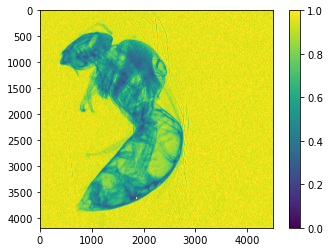

In [14]:
proj_norm, ob_med, dc_med = rocku.normalize(proj_crop, ob_crop, dc_crop)
print(proj_norm.dtype)
print(proj_norm.shape)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
history_dict = rocku.log(history_dict, 'normalization', True)

In [15]:
proj_norm.max()

1724.6052

In [16]:
proj_norm = tomopy.misc.corr.remove_outlier(proj_norm, gamma_diff, ncore=ncore)

In [17]:
proj_norm.max()

1.8965517

In [18]:
proj_norm.min()

0.0

# Beam fluctuation correction (optional)

In [ ]:
###################### need to change start
bg_left = 4250
bg_right = 4400
bg_top = 5
bg_bottom = 1500
###################### need to change end
bg_stack = proj_norm[:, bg_top:bg_bottom, bg_left:bg_right]
bg_min = np.min(bg_stack, axis=0)
print("Beam fluctuation ROI:")
plt.imshow(bg_min, vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [ ]:
t0 = timeit.default_timer()
proj_norm = tomopy.prep.normalize.normalize_roi(proj_norm, roi= [bg_top, bg_left, bg_bottom, bg_right], ncore=ncore)
plt.imshow(proj_norm[0], vmin=0, vmax=1)
plt.colorbar()
plt.show()
t1 = timeit.default_timer()
print("Time: {} s".format(t1-t0))
bg_roi_dict = {
    'left': bg_left,
    'right': bg_right,
    'top': bg_top,
    'bottom': bg_bottom
}
history_dict = rocku.log(history_dict, 'beam_fluc_corr', True)
history_dict = rocku.log(history_dict, 'beam_fluc_corr_roi', bg_roi_dict)

# Minus log conversion

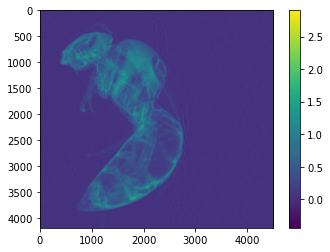

In [19]:
proj_mlog = tomopy.minus_log(proj_norm, ncore=ncore)
plt.imshow(proj_mlog[0])
plt.colorbar()
plt.show()
history_dict = rocku.log(history_dict, 'minus_log', True)

In [20]:
proj_mlog.min()

-0.64003736

In [21]:
proj_mlog.max()

inf

In [22]:
proj_mlog = tomopy.misc.corr.remove_outlier(proj_norm, gamma_diff, ncore=ncore)

In [25]:
proj_mlog.max()

1.8965517

In [26]:
proj_mlog.min()

0.0

# Find and correct tilt

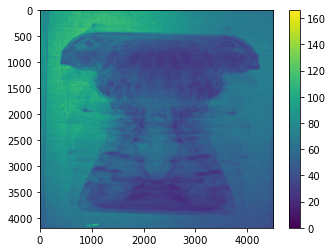

(4189, 4489)

In [27]:
plt.imshow(proj_crop_min)
plt.colorbar()
plt.show()
proj_crop_min.shape

Tilt correction ROI at 0 degree:


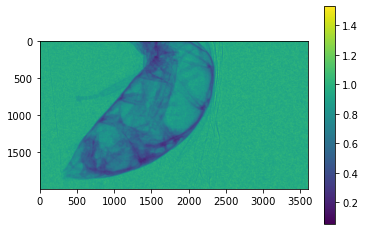

Tilt correction ROI at 180 degree:


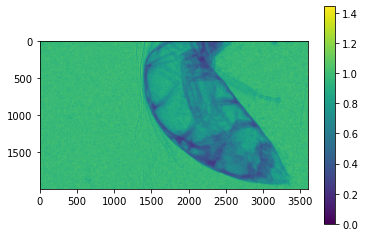

In [33]:
###################### need to change start
tt_left = 400
tt_right = 4000
tt_top = 2000
tt_bottom = 4000
###################### need to change start
tt_roi_dict = {
    'left': tt_left,
    'right': tt_right,
    'top': tt_top,
    'bottom': tt_bottom
}
tt_000deg_mlog = proj_mlog[proj000_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
tt_180deg_mlog = proj_mlog[proj180_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
tt_000deg_trans = proj_norm[proj000_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
tt_180deg_trans = proj_norm[proj180_idx, tt_roi_dict['top']:tt_roi_dict['bottom'], tt_roi_dict['left']:tt_roi_dict['right']]
print("Tilt correction ROI at 0 degree:")
# plt.imshow(tt_000deg_trans)
# plt.colorbar()
# plt.show()
plt.imshow(tt_000deg_mlog)
plt.colorbar()
plt.show()
print("Tilt correction ROI at 180 degree:")
# plt.imshow(tt_180deg_trans)
# plt.colorbar()
# plt.show()
plt.imshow(tt_180deg_mlog)
plt.colorbar()
plt.show()

In [34]:
print("Finding the tilt angle using transmission images...")
tilt_ang = tilt.calculate_tilt(image0=tt_000deg_trans, image180=tt_180deg_trans)
print("Found the tilt angle: ", tilt_ang.x)

Finding the tilt angle using transmission images...
Found the tilt angle:  0.04707130666325763


In [35]:
print("Finding the tilt angle using minus log images...")
tilt_ang = tilt.calculate_tilt(image0=tt_000deg_mlog, image180=tt_180deg_mlog)
print("Found the tilt angle: ", tilt_ang.x)

Finding the tilt angle using minus log images...
Found the tilt angle:  0.04707130666325763


In [36]:
t0 = timeit.default_timer()
# tilt_ang.x = 0.1248
proj_mlog_tilt = tilt.apply_tilt_correction(proj_mlog, tilt_ang.x, ncore=ncore)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
history_dict = rocku.log(history_dict, 'tilt_corr_roi', tt_roi_dict)
history_dict = rocku.log(history_dict, 'tilt_corr', tilt_ang.x)

Applying tilt corr:   0%|          | 0/286 [00:00<?, ?it/s]

Time cost 3.693702845213314 min


Projection at 0 degree:


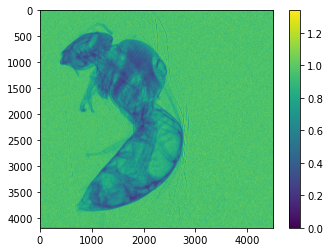

Projection at 180 degree (flipped):


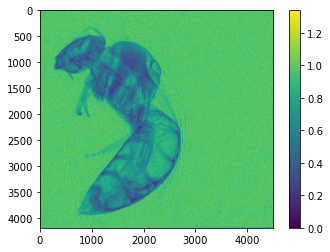

In [37]:
print("Projection at 0 degree:")
plt.imshow(proj_mlog_tilt[proj000_idx])# vmin=0, vmax=1)
plt.colorbar()
plt.show()
print("Projection at 180 degree (flipped):")
plt.imshow(np.fliplr(proj_mlog_tilt[proj180_idx]))# vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [38]:
history_dict

{'crop': False,
 'gamma_filter': True,
 'normalization': True,
 'minus_log': True,
 'tilt_corr_roi': {'left': 400, 'right': 4000, 'top': 2000, 'bottom': 4000},
 'tilt_corr': 0.04707130666325763}

# Ring Artifact Removal

Before ring removal:


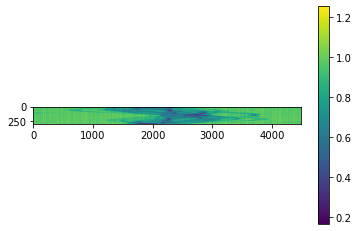

In [41]:
slice_num = 2000
print("Before ring removal:")
plt.imshow(proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()

## (a) Vo's approach from tomopy

In [ ]:
nchunk = int(proj_mlog.shape[0]/ncore) + 1
print("Chunk size: ", nchunk)
t0 = timeit.default_timer()
proj_mlog_rmv_vo = tomopy.remove_all_stripe(proj_mlog_tilt, ncore=ncore, nchunk=nchunk)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
history_dict = rocku.log(history_dict, 'ring_removal', 'Vo')

In [ ]:
slice_num = 600
print("Before ring removal:")
plt.imshow(proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()
print("After ring removal:")
plt.imshow(proj_mlog_rmv_vo[:, slice_num, :])
plt.colorbar()
plt.show()
print("Difference:")
plt.imshow(proj_mlog_rmv_vo[:, slice_num, :]-proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()

## (b) bm3d approach

In [ ]:
# t0 = timeit.default_timer()
# print("Perform 'extreme streak attenuation' (detection + median filter) on a 3-D stack of projections. First dimension should be angle.")
# proj_mlog_bm3d = bm3d.extreme_streak_attenuation(proj_mlog_tilt)
# print("Remove sinogram (after log transform) streak noise using multi-scale BM3D-based denoising procedure.")
# proj_mlog_rmv_bm3d = bm3d.multiscale_streak_removal(proj_mlog_bm3d)
# result = Parallel(n_jobs=ncore, prefer="threads")(delayed(bm3d.multiscale_streak_removal)(proj_mlog_bm3d[i], for i in range(n_slice))

# t1 = timeit.default_timer()
# print("Time cost {} min".format((t1-t0)/60))
# history_dict = rocku.log(history_dict, 'ring_removal', 'bm3d')

In [ ]:
t0 = timeit.default_timer()
print("Perform 'extreme streak attenuation' (detection + median filter) on a 3-D stack of projections. First dimension should be angle.")
proj_mlog_bm3d = bm3d.extreme_streak_attenuation(proj_mlog_tilt)
print("Remove sinogram (after log transform) streak noise using multi-scale BM3D-based denoising procedure.")
proj_mlog_rmv_bm3d = bm3d.multiscale_streak_removal(proj_mlog_bm3d)
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
history_dict = rocku.log(history_dict, 'ring_removal', 'bm3d')

Perform 'extreme streak attenuation' (detection + median filter) on a 3-D stack of projections. First dimension should be angle.
Median filtering, iteration 0
Median filtering, iteration 1
Median filtering, iteration 2
Remove sinogram (after log transform) streak noise using multi-scale BM3D-based denoising procedure.
Denoising sinogram 0
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 2
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 3
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 4
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 5
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 6
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 7
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 8
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 9
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 10
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 11
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denois

k: 3
k: 2
k: 1
k: 0
Denoising sinogram 138
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 139
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 140
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 141
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 142
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 143
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 144
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 145
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 146
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 147
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 148
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 149
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 150
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 151
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 152
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 153
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 154
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1

k: 0
Denoising sinogram 279
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 280
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 281
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 282
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 283
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 284
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 285
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 286
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 287
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 288
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 289
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 290
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 291
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 292
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 293
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 294
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 295
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising

k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 421
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 422
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 423
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 424
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 425
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 426
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 427
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 428
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 429
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 430
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 431
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 432
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 433
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 434
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 435
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 436
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 437
k: 6
k: 5
k: 4
k: 3

k: 2
k: 1
k: 0
Denoising sinogram 562
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 563
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 564
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 565
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 566
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 567
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 568
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 569
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 570
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 571
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 572
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 573
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 574
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 575
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 576
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 577
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 578
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0

Denoising sinogram 703
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 704
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 705
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 706
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 707
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 708
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 709
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 710
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 711
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 712
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 713
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 714
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 715
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 716
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 717
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 718
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 719
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sino

k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 845
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 846
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 847
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 848
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 849
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 850
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 851
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 852
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 853
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 854
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 855
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 856
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 857
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 858
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 859
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 860
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 861
k: 6
k: 5
k: 4
k: 3

k: 2
k: 1
k: 0
Denoising sinogram 986
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 987
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 988
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 989
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 990
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 991
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 992
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 993
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 994
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 995
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 996
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 997
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 998
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 999
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1000
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1001
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1002
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k

k: 0
Denoising sinogram 1125
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1126
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1127
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1128
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1129
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1130
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1131
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1132
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1133
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1134
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1135
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1136
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1137
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1138
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1139
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1140
k: 6
k: 5
k: 4
k: 3
k: 2
k: 1
k: 0
Denoising sinogram 1141
k: 6
k: 5
k: 4
k: 3
k: 2
k:

Before ring removal:


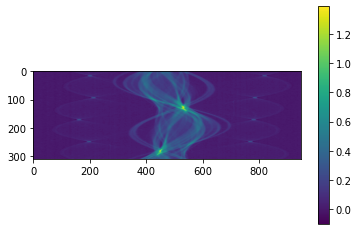

After ring removal:


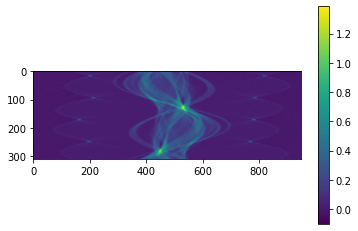

Difference:


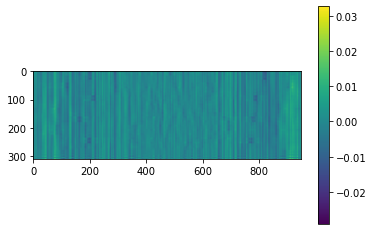

In [44]:
slice_num = 300
print("Before ring removal:")
plt.imshow(proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()
print("After ring removal:")
plt.imshow(proj_mlog_rmv_bm3d[:, slice_num, :])
plt.colorbar()
plt.show()
print("Difference:")
plt.imshow(proj_mlog_rmv_bm3d[:, slice_num, :]-proj_mlog_tilt[:, slice_num, :])
plt.colorbar()
plt.show()

# Find Center of Rotation

In [45]:
# proj_mlog_to_recon = proj_mlog_rmv_vo.astype(np.float32)
proj_mlog_to_recon = proj_mlog_rmv_bm3d.astype(np.float32)
sino_norm = np.moveaxis(proj_norm, 1, 0)
sino_mlog_to_recon = np.moveaxis(proj_mlog_to_recon, 1, 0)

In [46]:
rot_center = tomopy.find_center_pc(np.squeeze(proj_mlog_to_recon[proj000_idx,:,:]), np.squeeze(proj_mlog_to_recon[proj180_idx,:,:]), tol=0.5)
print('Estimated center of rotation:', rot_center)
history_dict = rocku.log(history_dict, 'rot_center', rot_center)

Estimated center of rotation: 492.0


In [47]:
# Use Vo's approach for 360 sinogram (180sinogram is calc.find_center_vo)
rot_center = calc.find_center_360(sino_mlog_to_recon[int(sino_mlog_to_recon.shape[0]/2)], win_width=800)[0]
# rot_center = calc.find_center_360(sino_mlog_to_recon[200], win_width=800)[0]
print('Estimated center of rotation:', rot_center)
history_dict = rocku.log(history_dict, 'rot_center', rot_center)

Estimated center of rotation: 491.4879398345947


# Reconstruction

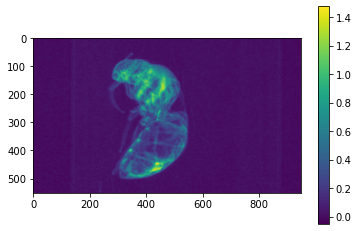

In [48]:
plt.imshow(proj_mlog_to_recon[1])
plt.colorbar()
plt.show()

491.4879398345947


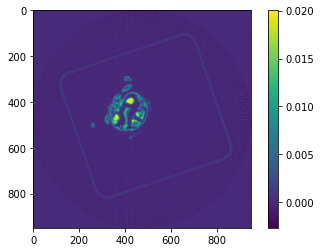

In [51]:
print(rot_center)
rec_img1 = rec.gridrec_reconstruction(sino_mlog_to_recon[200], rot_center, angles=ang_rad, apply_log=False)
plt.imshow(rec_img1)
plt.colorbar()
plt.show()

In [52]:
proj_mlog_to_recon.shape

(311, 550, 950)

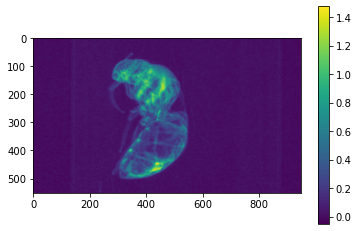

In [53]:
subset = False
# subset = True
if subset:
    _proj_mlog_to_recon = rocku.crop(proj_mlog_to_recon, 0, proj_mlog_to_recon.shape[2]-1, 600, 1200, subset)
else:
    _proj_mlog_to_recon = proj_mlog_to_recon[:]
plt.imshow(_proj_mlog_to_recon[1])
plt.colorbar()
plt.show()

In [54]:
t0 = timeit.default_timer()
recon_algo = 'gridrec'
########## tomopy
nchunk = int(proj_mlog.shape[0]/ncore) + 1
print("Chunk size: ", nchunk)
recon = tomopy.recon(_proj_mlog_to_recon, ang_rad, center=rot_center, algorithm=recon_algo, ncore=ncore, nchunk=nchunk)
# ########## svMBIR
# recon = recon(proj_tilt, theta, rot_center=rot_center, algorithm='svMBIR')
t1 = timeit.default_timer()
print("Time cost {} min".format((t1-t0)/60))
history_dict = rocku.log(history_dict, 'recon_algo', recon_algo)

Chunk size:  7
Time cost 0.020876345379898947 min


In [55]:
pix_um = 42.7 #um
pix_cm = pix_um/10000
recon_cm = recon/pix_cm
history_dict = rocku.log(history_dict, 'pixel_size_um', pix_um)

# Export recon files

In [56]:
################ change save path for your own
# save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/autoreduce/rockit/" + sample_name# + "_vo"
save_to = "/HFIR/CG1D/IPTS-"+ipts+"/shared/processed_data/rockit/" + sample_name# + "_600_1200"
print('Saving files to ', save_to)
dxchange.write_tiff_stack(recon_cm, fname=save_to + "/recon", overwrite=True, digit=4)

Saving files to  /HFIR/CG1D/IPTS-27734/shared/processed_data/rockit/2022_12_07


# Export to HDF5

In [57]:
history_dict

{'crop': True,
 'crop_roi': {'left': 550, 'right': 1500, 'top': 900, 'bottom': 1450},
 'gamma_filter': True,
 'normalization': True,
 'beam_fluc_corr': True,
 'beam_fluc_corr_roi': {'left': 5, 'right': 40, 'top': 5, 'bottom': 500},
 'minus_log': True,
 'tilt_corr_roi': {'left': 0, 'right': 950, 'top': 0, 'bottom': 550},
 'tilt_corr': 0.4360356126799792,
 'ring_removal': 'bm3d',
 'rot_center': 491.4879398345947,
 'recon_algo': 'gridrec',
 'pixel_size_um': 42.7}

In [58]:
if not os.path.exists(output_hdf5_dir):
    os.mkdir(output_hdf5_dir)
with h5f.File(output_hdf5, mode='a') as f:
    f.create_group('tomo/raw_ref')
    f.create_dataset('tomo/raw_ref/proj_min', data=proj_min)
    f.create_dataset('tomo/raw_ref/ob_min', data=ob_min)
    f.create_dataset('tomo/raw_ref/dc_max', data=dc_max)
    f.create_dataset('tomo/raw_ref/proj_crop_roi_min', data=proj_crop_min)
    f.create_dataset('tomo/raw_ref/fluc_corr_roi_min', data=bg_min)
    f.create_group('tomo/proj')
    f.create_dataset('tomo/proj/proj_norm', data=proj_norm)
    f.create_dataset('tomo/proj/proj_mlog_to_recon', data=proj_mlog_to_recon)
    f.create_dataset('tomo/proj/ob_fake', data=np.ones((proj_norm.shape[1], proj_norm.shape[2]), dtype=np.uint8))
    f.create_dataset('tomo/proj/dc_fake', data=np.zeros((proj_norm.shape[1], proj_norm.shape[2]), dtype=np.uint8))
    f.create_group('tomo/sino')
    f.create_dataset('tomo/sino/sino_norm', data=sino_norm)
    f.create_dataset('tomo/sino/sino_mlog_to_recon', data=sino_mlog_to_recon)
    f.create_group('tomo/info')
    f.create_dataset('tomo/info/ang_deg', data=ang_deg, dtype=np.float32)
    f.create_dataset('tomo/info/ang_rad', data=ang_rad, dtype=np.float64)
    f.create_dataset('tomo/info/proj180_idx', data=(proj180_idx,), dtype=np.uint16)
    f.create_dataset('tomo/info/proj000_idx', data=(proj000_idx,), dtype=np.uint16)
    f.create_dataset('tomo/info/fname', data=fname_sorted)
    f.create_group('tomo/recon')
    f.create_dataset('tomo/recon/history', data=(str(history_dict),))
    f.create_dataset('tomo/recon/recon_unit', data=('cm-1',))
    f.create_dataset('tomo/recon/recon_volume', data=recon_cm)

In [ ]:
if not os.path.exists(output_hdf5_dir):
    os.mkdir(output_hdf5_dir)
with h5f.File(output_hdf5, mode='a') as f:
    f.create_group('tomo/raw_ref')
    f.create_dataset('tomo/raw_ref/proj_min', data=proj_min)
    f.create_dataset('tomo/raw_ref/ob_min', data=ob_min)
    f.create_dataset('tomo/raw_ref/dc_max', data=dc_max)
    f.create_dataset('tomo/raw_ref/proj_crop_roi_min', data=proj_crop_min)
    f.create_dataset('tomo/raw_ref/fluc_corr_roi_min', data=bg_min)
    f.create_group('tomo/proj')
    f.create_dataset('tomo/proj/proj_norm', data=proj_norm)
#     f.create_dataset('tomo/proj/proj_mlog_to_recon', data=proj_mlog_to_recon)
    f.create_dataset('tomo/proj/ob_fake', data=np.ones((proj_norm.shape[1], proj_norm.shape[2]), dtype=np.uint8))
    f.create_dataset('tomo/proj/dc_fake', data=np.zeros((proj_norm.shape[1], proj_norm.shape[2]), dtype=np.uint8))
    f.create_group('tomo/sino')
#     f.create_dataset('tomo/sino/sino_norm', data=sino_norm)
#     f.create_dataset('tomo/sino/sino_mlog_to_recon', data=sino_mlog_to_recon)
    f.create_group('tomo/info')
    f.create_dataset('tomo/info/ang_deg', data=ang_deg, dtype=np.float32)
    f.create_dataset('tomo/info/ang_rad', data=ang_rad, dtype=np.float64)
    f.create_dataset('tomo/info/proj180_idx', data=(proj180_idx,), dtype=np.uint16)
    f.create_dataset('tomo/info/proj000_idx', data=(proj000_idx,), dtype=np.uint16)
    f.create_dataset('tomo/info/fname', data=fname_sorted)
    f.create_group('tomo/recon')
    f.create_dataset('tomo/recon/history', data=(str(history_dict),))
#     f.create_dataset('tomo/recon/recon_unit', data=('cm-1',))
#     f.create_dataset('tomo/recon/recon_volume', data=recon_cm)

In [45]:
losa.get_hdf_tree(output_hdf5)

 tomo
    │
    ├── info
    │   │
    │   ├── ang_deg (783,)
    │   ├── ang_rad (783,)
    │   ├── fname (783,)
    │   ├── proj000_idx (1,)
    │   └── proj180_idx (1,)
    ├── proj
    │   │
    │   ├── dc_fake (1850, 750)
    │   ├── ob_fake (1850, 750)
    │   ├── proj_mlog_to_recon (783, 1850, 750)
    │   └── proj_norm (783, 1850, 750)
    ├── raw_ref
    │   │
    │   ├── dc_max (2048, 2048)
    │   ├── fluc_corr_roi_min (800, 95)
    │   ├── ob_min (2048, 2048)
    │   ├── proj_crop_roi_min (1850, 750)
    │   └── proj_min (2048, 2048)
    ├── recon
    │   │
    │   ├── history (1,)
    │   ├── recon_unit (1,)
    │   └── recon_volume (1850, 750, 750)
    └── sino
        │
        ├── sino_mlog_to_recon (1850, 783, 750)
        └── sino_norm (1850, 783, 750)


deque([' tomo',
       '    │',
       '    ├── info',
       '    │   │',
       '    │   ├── ang_deg (783,)',
       '    │   ├── ang_rad (783,)',
       '    │   ├── fname (783,)',
       '    │   ├── proj000_idx (1,)',
       '    │   └── proj180_idx (1,)',
       '    ├── proj',
       '    │   │',
       '    │   ├── dc_fake (1850, 750)',
       '    │   ├── ob_fake (1850, 750)',
       '    │   ├── proj_mlog_to_recon (783, 1850, 750)',
       '    │   └── proj_norm (783, 1850, 750)',
       '    ├── raw_ref',
       '    │   │',
       '    │   ├── dc_max (2048, 2048)',
       '    │   ├── fluc_corr_roi_min (800, 95)',
       '    │   ├── ob_min (2048, 2048)',
       '    │   ├── proj_crop_roi_min (1850, 750)',
       '    │   └── proj_min (2048, 2048)',
       '    ├── recon',
       '    │   │',
       '    │   ├── history (1,)',
       '    │   ├── recon_unit (1,)',
       '    │   └── recon_volume (1850, 750, 750)',
       '    └── sino',
       '        │',
       '        